# Generating Synthetic Data with AGENT Framework
## Introduction
This document illustrates the process of generating synthetic data using the Antigranular Enterprise (AGENT) framework. By leveraging AGENT, we aim to produce a dataset that mimics the statistical properties of the original diamonds dataset while ensuring the privacy of the underlying data through differential privacy techniques.

## Setup and Configuration
Before generating synthetic data, we import necessary libraries and configure the AGENT framework with the required settings, including the server URL and API key for authentication.

In [ ]:
!pip install antigranular_enterprise -U 1> /dev/null 2> /dev/null
import antigranular_enterprise as ag
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# These details will be used going forward, you can have and toggle between multiple profiles
ag.write_config(profile='default', yaml_config="""
AGENT_JUPYTER_URL: https://agent.antigranular.com
AGENT_JUPYTER_PORT: 443
AGENT_CONSOLE_URL: http://agent-api-dev.antigranular.com
""")

# Connect in via your API key
ag.read_config("default")
session = ag.login(api_key="<api_key>")

Your request is pending approval. Please visit the following URL to approve the request: http://agent-dev.antigranular.com
Request approved.
Connected to Antigranular server session id: faba2199-9237-4c57-888b-c27fd2d7640c
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server


## Loading and Preparing the Dataset
We load the `diamonds` dataset from Seaborn and prepare it for synthesis by importing it into the AGENT session.

In [ ]:
# Load the dataset
diamonds = sns.load_dataset('diamonds')

# Display the first few rows of the dataframe
print(diamonds.head())

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


In [ ]:
session.private_import(diamonds, "df")

dataframe cached to server, loading to kernel...
DataFrame loaded successfully to the kernel



In [ ]:
%%ag
import op_pandas as opd

pdf = opd.PrivateDataFrame(
    df,
    metadata = {
        "carat": (0.0, 5.1),
        "depth": (40, 80),
        "table": (2, 100),
        "price": (100, 20000),
        "x": (0, 11),
        "y": (0, 60),
        "z": (0, 35),
    },
    categorical_metadata = {
        "cut": ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'],
        "color": ['E', 'I', 'J', 'H', 'F', 'G', 'D'],
        "clarity": ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
    }
)

## Synthesizing Data with AGENT
Using AGENT's op_snsynth module, we create a synthesizer object and generate synthetic data that resembles the original dataset in statistical properties but is generated in a way that protects the privacy of the underlying data.

In [ ]:
%%ag
import op_snsynth
import pandas as pd

categorical_columns = list(pdf.categorical_metadata.keys())

synth = op_snsynth.Synthesizer.create('mst', epsilon=1.0, verbose=True)
sample = synth.fit_sample(
  pdf,
  categorical_columns = list(pdf.categorical_metadata.keys()),
  continuous_columns = list(pdf.metadata.keys()),
  preprocessor_eps=0.5,
  nullable=True
)

Fitting with 552960000000 dimensions

Getting cliques

Estimating marginals



In [ ]:
%%ag
export(sample, "samples")

Setting up exported variable in local environment: samples


## Analyzing the Synthetic Data

After generating the synthetic data, we compare its statistical properties to the original dataset. This comparison helps validate the utility of the synthetic data for analytical purposes.

In [ ]:
import pandas as pd
import numpy as np

def compare_describe(desc1, desc2):
  # Manually construct a new DataFrame
  combined_stats = pd.DataFrame()
  combined_stats.index.name = f'True | ε-DP'

  for col in desc1.columns:
      for index in desc1.index:
          val1 = desc1.at[index, col]
          val2 = desc2.at[index, col]
          combined_stats.at[index, col] = f"{val1} | {val2}"

  return combined_stats

# Compare descriptive statistics
compare_describe(diamonds.describe().round(2), samples.describe().round(2))

,carat,depth,table,price,x,y,z
True | ε-DP,,,,,,,
count,53940.0 | 53937.0,53940.0 | 53909.0,53940.0 | 53934.0,53940.0 | 53915.0,53940.0 | 53937.0,53940.0 | 53929.0,53940.0 | 53917.0
mean,0.8 | 0.79,61.75 | 63.8,57.46 | 56.88,3932.8 | 4289.11,5.73 | 5.7,5.73 | 5.7,3.54 | 3.59
std,0.47 | 0.51,1.43 | 4.05,2.23 | 2.93,3989.44 | 3813.93,1.12 | 1.28,1.14 | 1.27,0.71 | 0.7
min,0.2 | 0.2,43.0 | 36.8,43.0 | 36.8,326.0 | 1881.6,0.0 | 2.7,0.0 | 2.7,0.0 | 2.3
25%,0.4 | 0.6,61.0 | 65.6,56.0 | 56.0,950.0 | 1881.6,4.71 | 4.1,4.72 | 4.1,2.91 | 2.9
50%,0.7 | 0.6,61.8 | 65.6,57.0 | 56.0,2401.0 | 1881.6,5.7 | 5.5,5.71 | 5.5,3.53 | 3.5
75%,1.04 | 1.0,62.5 | 65.6,59.0 | 56.0,5324.25 | 5132.8,6.54 | 6.9,6.54 | 6.9,4.04 | 4.1
max,5.01 | 3.8,79.0 | 123.2,95.0 | 123.2,18823.0 | 31142.4,10.74 | 15.3,58.9 | 15.3,31.8 | 7.7


<Axes: >

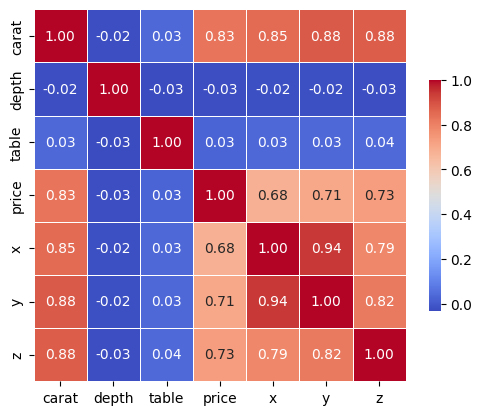

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = samples.select_dtypes("float").corr()

# Set up the matplotlib figure
plt.figure(figsize=(6, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


<Axes: >

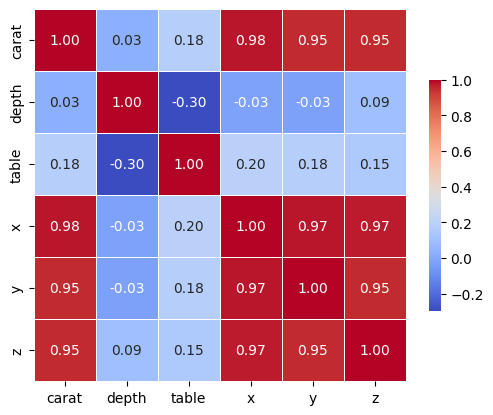

In [ ]:
corr_matrix = diamonds.select_dtypes("float").corr()

# Set up the matplotlib figure
plt.figure(figsize=(6, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})